import libraries

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, CategoryParameter, expand_plist, FieldSelector, Parameter, wwr
from besos.problem import EPProblem
plt.rcParams['figure.figsize'] = [8, 8]

# Parametric Analysis
This notebook performs a parametric analysis of a building design using EnergyPlus and BESOS helper functions.  
We load a model from in.idf, define parameters to vary, set objectives,then run the model for all parameter combinations and plot the results.

The EnergyPlus evaulator object `EvaluatorEP` consists of an `EPProblem` (`Parameters` to modify and `objectives` to report) and a `building` model.  
A problem (`problem = parameters + objectives`) can be easily applied to any building model (`evaluator = problem + building`).  

Each building is described by an `.idf` or `epJSON` file.  
In order to modify it programatically, we load it as a Python object using wrappers for EEPy.

If you are using the newer JSON format, then any JSON parsing library will work.

In [119]:
filename = 'model_final_single'

In [120]:
building = ef.get_building('/home/brendan/Desktop/polito/ICTBuilding/labBuilding/'+filename+'.idf')

Let's check what materials are in the model.  
([Eppy's documentation](https://eppy.readthedocs.io/en/latest/) describes how to explore and modify the IDF object directly.)

In [121]:
[materials.Name for materials in building.idfobjects["MATERIAL"]] # get a list of the Name property of all IDF objects of class MATERIAL

['Cast Concrete (Dense)_.1',
 'Asphalt 1_.O1',
 'MW Glass Wool (rolls)_.1445',
 'Plasterboard_.O13',
 'Gypsum Plasterboard_.O25',
 'Cement/plaster/mortar - cement_.O3',
 'XPS Extruded Polystyrene  - CO2 Blowing_.2',
 'Aerated Concrete Block_.2']

Selectors identify which part of the building model to modify and how to modify it (see the [Selectors](Evaluators/Selectors.ipynb) notebook for details).  
The `Selector` below specifies the `Thickness` field of an object named `Mass NonRes Wall Insulation`.

In [122]:
insulation = FieldSelector(class_name='Material',\
                           object_name='XPS Extruded Polystyrene  - CO2 Blowing_.2',\
                           field_name='Thickness')
ach_bedroom = FieldSelector(class_name='ZoneVentilation:DesignFlowRate',object_name='Block1:Bedroom Nat Vent', field_name='Air Changes per Hour')
ach_bathroom=FieldSelector(class_name='ZoneVentilation:DesignFlowRate',object_name='Block1:Bathroom Nat Vent', field_name='Air Changes per Hour')
ach_kitchen=FieldSelector(class_name='ZoneVentilation:DesignFlowRate',object_name='Block1:Kitchen Nat Vent', field_name='Air Changes per Hour')
shading_bedroom = FieldSelector(class_name='WindowShadingControl',object_name='1001-Block1:Bedroom', field_name='Setpoint')
shading_bathroom = FieldSelector(class_name='WindowShadingControl',object_name='1002-Block1:Bathroom', field_name='Setpoint')
shading_kitchen = FieldSelector(class_name='WindowShadingControl',object_name='1003-Block1:Kitchen', field_name='Setpoint')


#### Descriptors
Descriptors specify what values are valid for a parameter, see the [Descriptors](Evaluators/Descriptors.ipynb) for details.  
If we want to vary a parameter $0.01 \leq x \leq 0.99$, we can use a `RangeParameter`:

In [123]:
zero_to_one_exclusive = CategoryParameter(options=[0.00001, 0.10, 0.20])
ach_parameters = CategoryParameter(options=[0,5])
shading_parameters = CategoryParameter(options=[120,2000])

We can combine this with the `Selector` above to get a `Parameter`:

In [124]:
insulation_param = Parameter(selector=insulation,
                                 value_descriptor=zero_to_one_exclusive,
                                 name='Insulation Thickness')

ach_bedroom_param = Parameter(selector=ach_bedroom,
                                 value_descriptor=ach_parameters,
                                 name='Air Changes per Hour Bedroom')

ach_bathroom_param = Parameter(selector=ach_bathroom,
                                 value_descriptor=ach_parameters,
                                 name='Air Changes per Hour Bathroom')

ach_kitchen_param = Parameter(selector=ach_kitchen,
                                 value_descriptor=ach_parameters,
                                 name='Air Changes per Hour Kitchen')

shading_bedroom_param=Parameter(selector=shading_bedroom,
                                 value_descriptor=shading_parameters,
                                 name='Shading Bedroom')

shading_bathroom_param=Parameter(selector=shading_bathroom,
                                 value_descriptor=shading_parameters,
                                 name='Shading Bathroom')

shading_kitchen_param=Parameter(selector=shading_kitchen,
                                 value_descriptor=shading_parameters,
                                 name='Shading Kitchen')


#### Short-cuts for defining parameters
The `expand_plist` funcion can define `Parameters` more concisely. It takes a nested dictionary as input.  
The keys in the first layer of this dictionary are the names of the idf objects.  
These are associated with a dictionary that has keys matching the Fields of that object to modify.  
Each field-key corresponds to a tuple containing the minimum and maximum values for that parameter.  
The `class_name` is not specified.  
Instead the model is searched for objects with the correct `object_name`.  
**Note - doesn't like duplicate object names!**.

more_parameters = expand_plist(
    # class_name is NOT provided
    #{'object_name':
    # {'field_name':(min, max)}}
    {'Theoretical Glass [167]':
     {'Conductivity':(0.1,5)
     }
    })

for p in more_parameters:
    print(p)

#### Parameter scripts
BESOS also includes some pre-defined parameter scripts:
+ `wwr(Range)` for window to wall ratio  

Here we define the WWR of all walls in the model to be between 10% and 90%.

In [125]:
window_to_wall = wwr(RangeParameter(0.1,0.9)) # use a special shortcut to get the window-to-wall parameter

#### Custom parameter scripts
Parameters can also be created by defining a function that takes an idf and a value and mutates the idf.  
These functions can be specific to a certain idf file, and can perform any arbitrary transformation.  
Creating these can be more involved, and is not covered in this example.

## Problems
`Problem` objects represent inputs and outputs.  
We have defined various inputs using `parameters` above, and we define objectives of heating and cooling use.

In [126]:
# Add all the parameters to a single parameters object.
#parameters = [insulation_param] + [window_to_wall]
parameters = [window_to_wall,insulation_param, ach_bedroom_param,ach_bathroom_param,ach_kitchen_param,shading_bedroom_param,shading_bathroom_param,shading_kitchen_param] 

# Let us try to optimize the Cooling and the Heating of facility at the same time
objectives = ['Electricity:Facility','DistrictCooling:Facility'] 
#'InteriorLights:Electricity' has correlation circa 1 with ELectricity:Facility, we remove it from the obj
# These are hourly values, default is sum all the hourly values

# Construct the problem 
problem = EPProblem(parameters, objectives) # Make a problem instance from the parameters and objectives

## Sampling
Once you have defined your parameters, you may want to generate some random possible buildings. Sampling functions allow you to do this.

In [127]:
# Full factorial sampling 
#samples = sampling.dist_sampler(sampling.full_factorial, problem, num_samples=5, level=2)

In [151]:
# LHS sampling 
samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=12)

In [152]:
samples

,Window to Wall Ratio,Insulation Thickness,Air Changes per Hour Bedroom,Air Changes per Hour Bathroom,Air Changes per Hour Kitchen,Shading Bedroom,Shading Bathroom,Shading Kitchen
0,0.849499,0.20000,0,0,5,2000,120,2000
1,0.406410,0.20000,0,5,5,120,120,120
2,0.108683,0.00001,5,0,0,120,2000,2000
3,0.490051,0.10000,0,5,5,120,2000,120
4,0.788155,0.10000,5,5,5,120,2000,2000
5,0.618223,0.00001,5,0,5,2000,120,120
6,0.250379,0.10000,0,5,5,120,120,2000
7,0.546731,0.00001,5,0,0,2000,120,120
8,0.341462,0.20000,5,0,0,2000,2000,2000
9,0.231618,0.00001,0,0,0,2000,120,2000


## Evaluation
Now we can evaluate the samples. We create an energy plus evaluator (`EvaluatroEP`) using the parameters, and idf describing the building, and the objectives we want to measure. For this example we will just use one of the premade objectives: Electricity use for the whole facility.

In [143]:
evaluator = EvaluatorEP(problem, building, out_dir='outputdir', err_dir='outputdir',epw='/home/brendan/Desktop/polito/ICTBuilding/labBuilding/larnaca.epw')
outputs = evaluator.df_apply(samples, keep_input=True)

outputs.describe()

,Window to Wall Ratio,Insulation Thickness,Air Changes per Hour Bedroom,Air Changes per Hour Bathroom,Air Changes per Hour Kitchen,Shading Bedroom,Shading Bathroom,Shading Kitchen,Electricity:Facility,DistrictCooling:Facility
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.00000,12.000000,12.000000,1.200000e+01,1.200000e+01
mean,0.466829,0.116668,2.916667,2.916667,3.333333,1060.00000,746.666667,746.666667,3.638869e+09,1.016008e+10
std,0.242421,0.057733,2.574643,2.574643,2.461830,981.79798,925.648012,925.648012,1.649948e+08,1.754697e+09
min,0.116175,0.000010,0.000000,0.000000,0.000000,120.00000,120.000000,120.000000,3.479948e+09,7.558843e+09
25%,0.328573,0.100000,0.000000,0.000000,0.000000,120.00000,120.000000,120.000000,3.526021e+09,9.200730e+09
50%,0.426263,0.100000,5.000000,5.000000,5.000000,1060.00000,120.000000,120.000000,3.590182e+09,9.802076e+09
75%,0.576190,0.125000,5.000000,5.000000,5.000000,2000.00000,2000.000000,2000.000000,3.681132e+09,1.096365e+10
max,0.881409,0.200000,5.000000,5.000000,5.000000,2000.00000,2000.000000,2000.000000,4.010705e+09,1.285957e+10


## Visualizing the results

First we can see the variation in the objectives:

Text(0, 0.5, 'DistrictCooling:Facility')

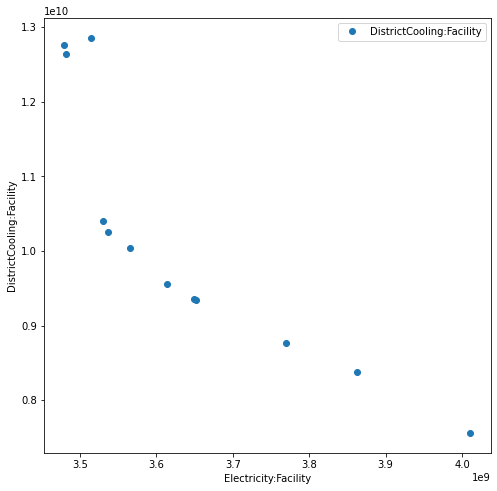

In [144]:
_ = outputs.plot(x=objectives[0], y=objectives[1], style = 'o')
plt.xlabel(objectives[0])
plt.ylabel(objectives[1])

And compare the trends in the input values as the heating objective increases:

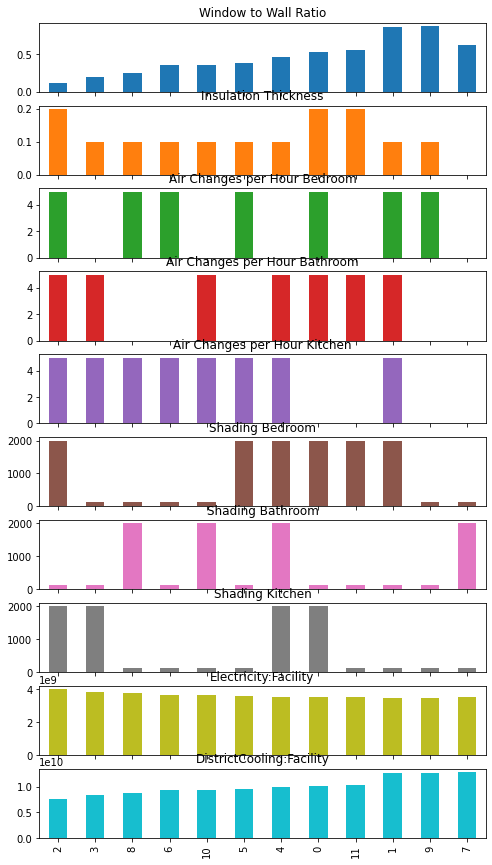

In [145]:
outputs = outputs.sort_values(by=objectives[1])
ax=outputs.plot.bar(subplots=True,legend=None, figsize=(8,15))

In [146]:
print((outputs))
#outputs.to_csv('output_files/' + filename + '.csv')
outputs.to_csv('output_files/' + 'test_seeded' + '.csv')


    Window to Wall Ratio  Insulation Thickness  Air Changes per Hour Bedroom  \
2               0.116175               0.20000                             5   
3               0.194620               0.10000                             0   
8               0.257266               0.10000                             5   
6               0.352343               0.10000                             5   
10              0.354387               0.10000                             0   
5               0.387606               0.10000                             5   
4               0.464920               0.10000                             0   
0               0.539051               0.20000                             5   
11              0.560757               0.20000                             0   
1               0.870930               0.10000                             5   
9               0.881409               0.10000                             5   
7               0.622487               0

## Visualising the parametric analysis

A better way to analyse the results is by looking at scatter plots of the inputs versus the outputs.  
This enables us to visually see strong relationships of inputs and outputs.

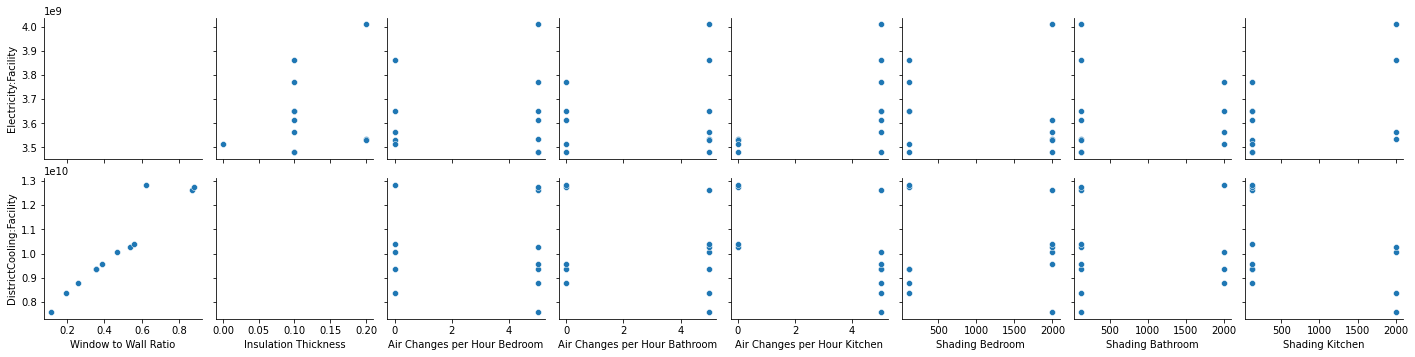

In [147]:
_=pairplot(outputs,x_vars=samples.columns, y_vars=objectives, kind="scatter")

### Correlation heat map
Another way to analyse the impact of the inputs on the outputs is by analysing the correlation.  
A common metric is the Pearsson correlation coefficient:

$ r = \frac{N\sum{XY}-(\sum{X}\sum{Y})}{\sqrt{ [N\sum{x^2}-(\sum{x})^2 ][N\sum{y^2}-(\sum{y})^2 }]} $

where N is the number of samples. $X$ is the vector of observation of variable 1 (e.g. wall conductivity) and $Y$ is the vetor of observations of variable 2 (e.g. electricity consumption).  
The closer $r$ is to one the stronger the correlation, and similarly for negative one and negative correleation.

To visualize the correlation coefficients of all inputs and outputs, we can plot a heatmap:

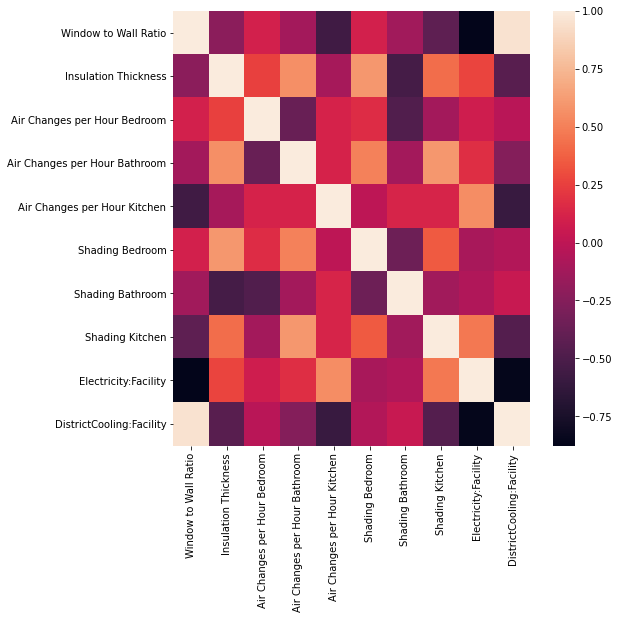

In [148]:
_ = heatmap(outputs.corr())

The heatmap shows well that the impact of 'Equipment' and 'Lighting' is the most important given this example of an office building.  
The U-Value and the attic insultation thickness have suprisingly little effect.  